## Librerias

In [1]:
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import numpy as np

## Coordenadas baricentricas y cartesianas

Respecto a una triangulación de Delaunay de un conjunto de puntos respecto al simplice k-ésimo.

In [15]:
def barycentric(delaunay,points,k): # k=id simplice
    n = len(points[0])
    b = delaunay.transform[k,:n].dot(np.transpose(points - delaunay.transform[k,n]))
    return np.c_[np.transpose(b), 1 - b.sum(axis=0)]

def cartesian(delaunay,barycentric,k):
    return barycentric.dot(delaunay.points[delaunay.simplices[k]])

Por ejemplo

In [10]:
dataset = (np.array([[0,0],[0,1],[1,0],[1,1],[-1,-1],[-1,2],[2,2],[-1,2],[2,-1]]),
           np.array([0,1,1,0,2,2,2,2,2]))
data = dataset[0]
classes = dataset[1]

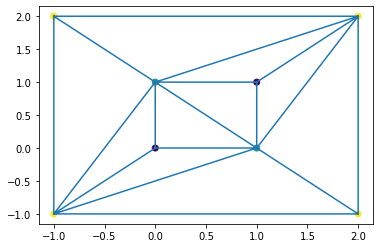

In [13]:
k = Delaunay(data)
plt.triplot(data[:,0], data[:,1], k.simplices)
plt.scatter(data[:,0], data[:,1],c=classes)
plt.show()

In [18]:
# La lista de símplices de la triangulación se obtiene:
k.simplices

array([[0, 1, 4],
       [1, 5, 4],
       [5, 1, 6],
       [1, 3, 6],
       [2, 0, 4],
       [8, 2, 4],
       [2, 1, 0],
       [1, 2, 3],
       [3, 2, 6],
       [2, 8, 6]], dtype=int32)

In [20]:
# La lista de vértices de la triangulación se obtiene:
k.points

array([[ 0.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  1.],
       [-1., -1.],
       [-1.,  2.],
       [ 2.,  2.],
       [-1.,  2.],
       [ 2., -1.]])

In [17]:
# Coordenadas baricéntricas de los puntos [(0.2,0.5),(1.7,2.1)] respecto al símplice [5, 1, 6]:
barycentric(k,[(0.2,0.5),(1.7,2.1)],2)

array([[-0.4       ,  1.5       , -0.1       ],
       [ 0.16666667, -0.1       ,  0.93333333]])

### Definición de la red neuronal

In [28]:
def nn(dataset,p):
    data = dataset[0] # LOS PUNTOS
    classes = dataset[1] # CLASES
    k = Delaunay(data) # COMPLEJO K
    l = Delaunay(np.array([[0,0],[0,1],[1,0]])) # COMPLEJO L
    b=barycentric(k,p,k.find_simplex(p)[0]) # BARICENTRICAS DE P EN K
    image = classes[k.simplices[k.find_simplex(p)]][0] 
    # TOMAMOS LAS BARICENTRICAS RESPECTO UNO DE LOS SIMPLICES 
    # A LOS QUE PERTENECE P, ES DECIR, COORDENADAS BARICÉNTRICAS POSITIVAS.
    # VERTICES IMAGEN DEL SIMPLICE QUE CONTIENE A P EN K
    f=b.dot(l.points[image])
    # CARTESIANAS IMAGEN DE P EN L
    return  barycentric(l,f,0) # BARICÉNTRICAS DE P EN L

#### Ejemplo:

Complejo simplicial L

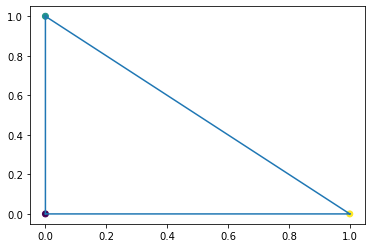

In [29]:
l = Delaunay(np.array([[0,0],[0,1],[1,0]]))
plt.triplot(l.points[:,0], l.points[:,1], l.simplices)
plt.scatter(l.points[:,0],l.points[:,1],c=np.array([0,1,2]))
plt.show()

In [30]:
nn(dataset,[(-0.1,1.1)])

array([[0.1, 0.9, 0. ]])

### Subdivisión baricéntrica

In [31]:
import itertools 

In [32]:
# Auxiliary function: 
# Input: list
# Output: subsets of a given size
def findsubsets(s, n): 
    return np.array(list(itertools.combinations(s, n)))

In [33]:
# Devuelve una 2-upla. El primer elemento es una lista de tuplas con los símplices
# y los índices de sus baricentros. El segundo elemento son todos los nuevos puntos.

# Barycentric subdivision of a given simplex.
# Input: A simplex (simplice in spanish) and points location of the vertices (puntos)
# Output: two lists. The first one is composed of indices of the new vertices
# with the simplices to compute it.
# The second list is composed of the locations of the new points.
def barycentric_subd(simplice,puntos):
    i=len(simplice)
    index = len(puntos)-1
    ls = []
    bs = []
    while i!=1:
        s1= findsubsets(simplice,i)#[0],i)
        b1= [np.sum(puntos[s],axis=0)/i for s in s1]
        xs = []
        for b in b1:
            bs.append(b)
            index+=1
            xs.append(index) 
        ls.append(np.array(list(zip(xs,s1))))
        i-=1
    s_ori= findsubsets(simplice,1)
    ls.append(np.array(list(zip(simplice,s_ori))))
    return (np.concatenate(ls),bs)


In [35]:
# Use the output of barycentric subdivision function to provide the maximal
# simplices of the barycentric subdivision.
# Input: output of barycentric subdivision and dimension of the maximal simplices     
def maximal_simp(t,dim):
    t1=t[0]
    lists = findsubsets(t1,dim+1)
    simps = []
    for l in lists:
        if ite_sublist(l[:,1]):
            simps.append(l[:,0])
    return simps
        
#Auxiliary function to check if a list lst1 is contained in other list lst2
def sublist(lst1, lst2):
    return (set(lst1) <= set(lst2))
 
# Generalization of the function of list to a sequence of lists.
def ite_sublist(ts):
    ls = []
    for i in range(len(ts)):
        a = all([sublist(ts[j],ts[i]) for j in range(i+1,len(ts))])
        ls.append(a)
    return all(ls)
        

# Barycentric subdivision of a simplicial complex.
def bar_subd_complex(simp_complex,puntos):
    ss = []
    p = puntos
    dim=len(simp_complex[0])-1
    for i in range(np.shape(simp_complex)[0]):
        b=barycentric_subd(simp_complex[i],p)
        m = maximal_simp(b,dim)
        p = np.concatenate((p,b[1]))
        ss.append(m)
    return((np.array(np.concatenate(ss),dtype=np.int),p))
        

#### Ejemplo

<ipython-input-33-0c7291b33819>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ls.append(np.array(list(zip(xs,s1))))
<ipython-input-33-0c7291b33819>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ls.append(np.array(list(zip(simplice,s_ori))))


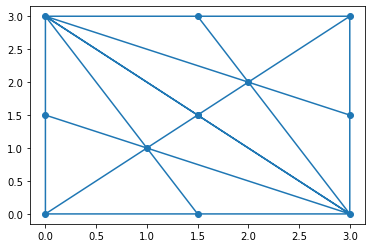

In [39]:
p = np.array([[0,3],[3,0],[0,0],[3,3]])
simplices = np.array([[0,1,2],[0,1,3]])

b=bar_subd_complex(simplices,p)
plt.triplot(b[1][:,0], b[1][:,1], b[0])
plt.scatter(b[1][:,0], b[1][:,1])
plt.show()

In [40]:
b

(array([[ 4,  5,  0],
        [ 4,  5,  1],
        [ 4,  6,  0],
        [ 4,  6,  2],
        [ 4,  7,  1],
        [ 4,  7,  2],
        [ 8,  9,  0],
        [ 8,  9,  1],
        [ 8, 10,  0],
        [ 8, 10,  3],
        [ 8, 11,  1],
        [ 8, 11,  3]]),
 array([[0. , 3. ],
        [3. , 0. ],
        [0. , 0. ],
        [3. , 3. ],
        [1. , 1. ],
        [1.5, 1.5],
        [0. , 1.5],
        [1.5, 0. ],
        [2. , 2. ],
        [1.5, 1.5],
        [1.5, 3. ],
        [3. , 1.5]]))